# Walmart Trip Type Classification

In [1]:
from itertools import combinations
import editdistance
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.offline as py
import plotly.graph_objs as go
import plotly.figure_factory as ff
py.init_notebook_mode(connected=True)


#Model selection and model building libraries


#Data Manipulation
from sklearn.model_selection import train_test_split

#Data Preprocessing
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder

#Models
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

#Model Selection
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import GridSearchCV


#Metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import log_loss

## Helper functions

In [2]:
#Helper function for plotting distributions
def plot_distribution(lst,title,xlabel,ylabel):
    dic = {}
    for item in lst:
        if item not in dic.keys():
            dic[item] =1
        else:
            dic[item] +=1 
 
    layout = {
      'xaxis': {'title': xlabel,'type':'category'},
      'yaxis': {'title': ylabel},
      'title':title
    }
    trace = [go.Bar(
            x=[str(value) for value in dic.keys()],
            y=list(dic.values()),
    )]

    py.iplot({'data':trace,'layout':layout}, filename='basic-bar')

#Helper function to plot a Pie chart
def plot_pie_chart(lst,title):
    dic = {}
    for item in lst:
        if item not in dic.keys():
            dic[item] =1
        else:
            dic[item] +=1 

    layout = {
      'title':title
    }
    trace = [go.Pie(
            labels=[str(value) for value in dic.keys()],
            values=list(dic.values()),
    )]

    py.iplot({'data':trace,'layout':layout}, filename='basic-bar')    

## Import data

In [30]:
data = pd.read_csv('data/train.csv')

In [47]:
#Convert Trip type to a category
data['TripType'] = data['TripType'].astype('category')
data['FinelineNumber'] = data['FinelineNumber'].astype(str)
data['Upc'] = data['Upc'].astype(str)
data['VisitNumber'] = data['VisitNumber'].astype('category')

## Explore the data

#### Data fields
- TripType - a categorical id representing the type of shopping trip the customer made. This is the ground truth to predict. TripType_999 is an "other" category.
- VisitNumber - an id corresponding to a single trip by a single customer
- Weekday - the weekday of the trip
- Upc - the UPC number of the product purchased
- ScanCount - the number of the given item that was purchased. A negative value indicates a product return.
- DepartmentDescription - a high-level description of the item's department
- FinelineNumber - a more refined category for each of the products, created by Walmart

In [48]:
data.head()

,TripType,VisitNumber,Weekday,Upc,ScanCount,DepartmentDescription,FinelineNumber
0,999,5,Friday,68113152929.0,-1,FINANCIAL SERVICES,1000.0
1,30,7,Friday,60538815980.0,1,SHOES,8931.0
2,30,7,Friday,7410811099.0,1,PERSONAL CARE,4504.0
3,26,8,Friday,2238403510.0,2,PAINT AND ACCESSORIES,3565.0
4,26,8,Friday,2006613744.0,2,PAINT AND ACCESSORIES,1017.0


In [49]:
data.describe()

,ScanCount
count,647054.000000
mean,1.108878
std,0.700776
min,-12.000000
25%,1.000000
50%,1.000000
75%,1.000000
max,71.000000


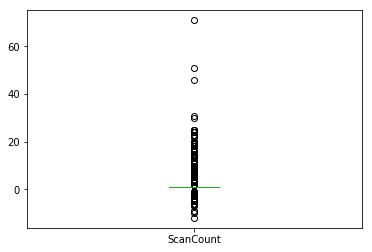

In [37]:
#Data consists of a few outliers
data['ScanCount'].plot(kind='box')

In [38]:
data.loc[data['ScanCount']==71]

,TripType,VisitNumber,Weekday,Upc,ScanCount,DepartmentDescription,FinelineNumber
478028,32,142397,Saturday,4.178900e+09,71,GROCERY DRY GOODS,3120.0


In [39]:
data.loc[data['VisitNumber']==142397]

,TripType,VisitNumber,Weekday,Upc,ScanCount,DepartmentDescription,FinelineNumber
478008,32,142397,Saturday,4.178900e+09,22,GROCERY DRY GOODS,3120.0
478009,32,142397,Saturday,7.152113e+10,1,INFANT APPAREL,2300.0
478010,32,142397,Saturday,7.152113e+10,1,INFANT APPAREL,2300.0
478011,32,142397,Saturday,8.834761e+10,1,MEDIA AND GAMING,9625.0
478012,32,142397,Saturday,7.152113e+10,1,INFANT APPAREL,2300.0
478013,32,142397,Saturday,8.179990e+10,1,IMPULSE MERCHANDISE,8904.0
478014,32,142397,Saturday,4.721361e+09,2,INFANT APPAREL,1106.0
478015,32,142397,Saturday,3.417761e+11,1,INFANT CONSUMABLE HARDLINES,402.0
478016,32,142397,Saturday,7.152113e+10,1,INFANT APPAREL,6126.0
478017,32,142397,Saturday,2.519228e+09,1,MEDIA AND GAMING,9625.0


In [40]:
data.loc[data['ScanCount']==-12]

,TripType,VisitNumber,Weekday,Upc,ScanCount,DepartmentDescription,FinelineNumber
124100,39,36866,Wednesday,4.178900e+09,-12,GROCERY DRY GOODS,3120.0


In [41]:
data.loc[data['VisitNumber']==36866]

,TripType,VisitNumber,Weekday,Upc,ScanCount,DepartmentDescription,FinelineNumber
124094,39,36866,Wednesday,4.178900e+09,1,GROCERY DRY GOODS,3120.0
124095,39,36866,Wednesday,2.840016e+09,1,IMPULSE MERCHANDISE,808.0
124096,39,36866,Wednesday,5.200033e+09,1,DSD GROCERY,4606.0
124097,39,36866,Wednesday,3.408667e+09,1,BEDDING,9970.0
124098,39,36866,Wednesday,3.408667e+09,1,BEDDING,9970.0
124099,39,36866,Wednesday,4.178900e+09,11,GROCERY DRY GOODS,3120.0
124100,39,36866,Wednesday,4.178900e+09,-12,GROCERY DRY GOODS,3120.0
124101,39,36866,Wednesday,4.400001e+09,1,DSD GROCERY,3862.0
124102,39,36866,Wednesday,7.311497e+10,1,SEAFOOD,1077.0
124103,39,36866,Wednesday,2.840033e+09,1,DSD GROCERY,4402.0


In [42]:
data.loc[data['ScanCount']<=-1]

,TripType,VisitNumber,Weekday,Upc,ScanCount,DepartmentDescription,FinelineNumber
0,999,5,Friday,6.811315e+10,-1,FINANCIAL SERVICES,1000.0
9,26,8,Friday,2.238400e+09,-1,PAINT AND ACCESSORIES,3565.0
14,26,8,Friday,8.867930e+10,-1,PAINT AND ACCESSORIES,3504.0
297,9,132,Friday,6.454161e+10,-1,CELEBRATION,6.0
299,9,132,Friday,6.700886e+09,-1,CELEBRATION,6.0
300,999,133,Friday,9.933894e+09,-1,LADIESWEAR,1180.0
369,999,182,Friday,5.473282e+09,-1,HARDWARE,8410.0
376,999,190,Friday,4.316875e+09,-1,HARDWARE,4513.0
389,7,199,Friday,4.138309e+09,-1,DAIRY,1505.0
404,38,210,Friday,2.200012e+09,-1,"CANDY, TOBACCO, COOKIES",221.0


In [43]:
data.loc[data['VisitNumber']==190]

,TripType,VisitNumber,Weekday,Upc,ScanCount,DepartmentDescription,FinelineNumber
376,999,190,Friday,4.316875e+09,-1,HARDWARE,4513.0


In [44]:
data['Weekday'].describe()

count     647054
unique         7
top       Sunday
freq      133975
Name: Weekday, dtype: object

In [45]:
data['DepartmentDescription'].describe()

count                645693
unique                   68
top       GROCERY DRY GOODS
freq                  70402
Name: DepartmentDescription, dtype: object

The department description is used as a proxy for department type.There are 68 different departments. 

In [46]:
data['TripType'].describe()

count    647054.000000
mean         58.584511
std         157.635533
min           3.000000
25%          27.000000
50%          39.000000
75%          40.000000
max         999.000000
Name: TripType, dtype: float64

There 38 different types of trip.

In [50]:
data['FinelineNumber'].describe()

count     647054
unique      5196
top       5501.0
freq        8244
Name: FinelineNumber, dtype: object

In [51]:
data['Upc'].describe()

count     647054
unique     97715
top       4011.0
freq        7657
Name: Upc, dtype: object

There are 5196 product category

## Identifying Missing Values

In [52]:
print("Number of missing values for DepartmentDescription: ",len(data[data['DepartmentDescription'].isnull()]))

Number of missing values for DepartmentDescription:  1361


In [59]:
#Where Fineline number is negative
print("Number of missing values for FinelineNumber: ",len(data[data['FinelineNumber']=='nan']))

Number of missing values for FinelineNumber:  4129


In [60]:
#Where Upc number is negative
print("Number of missing values for Upc: ",len(data[data['Upc'] =='nan']))

Number of missing values for Upc:  4129


In [61]:
print("Number of missing values for Weekday: ",len(data[data['Weekday'].isnull()]))

Number of missing values for Weekday:  0


In [62]:
print("Number of missing values for VisitNumber: ",len(data[data['VisitNumber'].isnull()]))

Number of missing values for VisitNumber:  0


In [63]:
print("Number of missing values for TripType: ",len(data[data['TripType'].isnull()]))

Number of missing values for TripType:  0


## Removing missing values

#### Distribution of classes before removing visits with missing values in Upc number, Fine Line Number and Department Description.

In [64]:
plot_distribution(data['TripType'],"Trip Type Distribution","Trip Type","Frequency")

In [65]:
#Remove Visits where Department Description is null
data = data[~data['VisitNumber'].isin(data['VisitNumber'][data['DepartmentDescription'].isnull()])]

In [69]:
#Remove Visits where Upc Number is Null i.e. when the Upc or FineLine Number is nan
data = data[~data['VisitNumber'].isin(data['VisitNumber'][data['Upc']=='nan'])]

In [70]:
print("Number of missing values for FinelineNumber: ",len(data[data['FinelineNumber']=='nan']))


Number of missing values for FinelineNumber:  0


In [121]:
print("Number of missing values for Upc: ",len(data[data['Upc'] =='nan']))

Number of missing values for Upc:  0


#### Distribution of classes after removing visits with missing values in Upc number, Fine Line Number and Department Description.

In [72]:
plot_distribution(data['TripType'],"Trip Type Distribution after removing Missing Values","Trip Type","Frequency")

## Cleaning up Department Description


In [74]:
for item1, item2 in combinations(set(data['DepartmentDescription']),2):
    diff = editdistance.eval(item1,item2)
    if diff >= 1 and diff <=6:
        print(item1," | ",item2)

MENSWEAR  |  MENS WEAR
MENSWEAR  |  LADIESWEAR
MENSWEAR  |  SEASONAL
MENSWEAR  |  BOYS WEAR
MENSWEAR  |  HARDWARE
DAIRY  |  BAKERY
DAIRY  |  BEAUTY
DAIRY  |  BEDDING
DAIRY  |  SEAFOOD
DAIRY  |  SHOES
DAIRY  |  TOYS
DAIRY  |  HARDWARE
MENS WEAR  |  LADIESWEAR
MENS WEAR  |  SEASONAL
MENS WEAR  |  BOYS WEAR
BAKERY  |  BEAUTY
BAKERY  |  BEDDING
BAKERY  |  SEAFOOD
BAKERY  |  SHOES
BAKERY  |  TOYS
BAKERY  |  HARDWARE
CAMERAS AND SUPPLIES  |  PETS AND SUPPLIES
LADIESWEAR  |  BOYS WEAR
LADIESWEAR  |  LADIES SOCKS
BEAUTY  |  SEASONAL
BEAUTY  |  BEDDING
BEAUTY  |  SEAFOOD
BEAUTY  |  SHOES
BEAUTY  |  TOYS
BEAUTY  |  PRODUCE
OPTICAL - LENSES  |  OPTICAL - FRAMES
PHARMACY RX  |  PHARMACY OTC
HOME DECOR  |  BOYS WEAR
SEASONAL  |  BEDDING
SEASONAL  |  SEAFOOD
SEASONAL  |  SHOES
BOYS WEAR  |  COMM BREAD
BOYS WEAR  |  TOYS
BEDDING  |  SEAFOOD
BEDDING  |  PRODUCE
FURNITURE  |  PRODUCE
FURNITURE  |  HARDWARE
SEAFOOD  |  SHOES
SEAFOOD  |  TOYS
WIRELESS  |  SHOES
SHOES  |  TOYS
SHOES  |  PRODUCE
TOYS  |  P

In [75]:
for index,row in data.iterrows(): 
    if row['DepartmentDescription'] == 'MENSWEAR':
        data.set_value(index,'DepartmentDescription','MENS WEAR')

In [78]:
len(data[data['DepartmentDescription'] == 'MENS WEAR'])

12280

## Cleaning up Upc and FineLine Number

In [86]:
upc_list = []
for upc in data['Upc']:
    upc_list.append(upc.split('.')[0])
data['Upc'] = upc_list

In [89]:
fineline_number_list = []
for fineline_number in data['FinelineNumber']:
    fineline_number_list.append(fineline_number.split('.')[0])
data['FinelineNumber'] = fineline_number_list

## Understanding UPC

##### UPC Number

The UPC (Universal Product Number) symbol is the barcode representation of the GTIN-12 which consists of twelve numeric characters that uniquely identify a company's individual product and consists of the company code, a product number and a checksum.

In [88]:
data['Upc'].describe()

count     628055
unique     96579
top         4011
freq        7489
Name: Upc, dtype: object

In [92]:
upc_length = []
for x in data['Upc']:
    upc_length.append(len(str(x))) 

In [93]:
plot_distribution(upc_length,"Upc Length Distribution","Upc length","Frequency")

### Decoding the Upc Value

<img src="https://www.gtin.info/wp-content/uploads/2013/12/diagram-upc-anatomy.gif" />

In [94]:
def checksum(x):
    """
    Calculate the checksum
    """
    try:
        odd = map(int, str(x)[-1::-2])
        even = map(int, str(x)[-2::-2])
        sum_odd3 = sum(odd) * 3
        total = sum_odd3 + sum(even)
        rem = total % 10
        if rem == 0:
            return rem
        return 10 - rem
    except:
        return -9999

In [95]:
def get_full_upc(x,only_pad=False):
    try:
        if len(str(x)) == 12:
            return x
        else:
            if only_pad == False:
                x = str(x) + str(checksum(x))
            if len(str(x)) < 12:
                missing = 12 - len(str(x))
                zeros = '0' * missing
                xx = zeros + str(x)
                return xx
            elif len(str(x)) == 12:
                return x
            else:
                return None
            
    except Exception as ex:
        return -9999

In [96]:
decoded_upc = [get_full_upc(upc) for upc in data['Upc']]

In [97]:
data['DecodedUpc'] = decoded_upc

In [98]:
decoded_upc_length = []
for x in data['DecodedUpc']:
    decoded_upc_length.append(len(str(x))) 

In [99]:
plot_distribution(decoded_upc_length,"Decoded Upc Length Distribution","Upc length","Frequency")

In [101]:
data['DecodedUpc'].describe()

count           628055
unique           96579
top       000000040112
freq              7489
Name: DecodedUpc, dtype: object

## Data Extraction from Walmart's API

In [105]:
from local import *

In [114]:
URL = 'http://api.walmartlabs.com/v1/items?'
payload = {
    'apiKey': API_KEY_2,
     'upc':None
}

In [115]:
write_to_data = pd.read_csv('data/clean_data_write_to.csv')

/Users/stefanmarwah/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning:

Columns (9,10,11,12) have mixed types. Specify dtype option on import or set low_memory=False.



In [ ]:
write_to_data['name'] = write_to_data['name'].astype(str)
write_to_data['brandName'] = write_to_data['brandName'].astype(str)
write_to_data['categoryPath'] = write_to_data['categoryPath'].astype(str)
write_to_data['offerType'] = write_to_data['offerType'].astype(str)

In [116]:
write_to_data.head(10)

,TripType,VisitNumber,Weekday,Upc,ScanCount,DepartmentDescription,FinelineNumber,DecodedUpc,salePrice,name,brandName,categoryPath,offerType,dataScraped
0,999,5,Friday,68113152929,-1,FINANCIAL SERVICES,1000,681131529297,NaN,Payroll Card Wm Unload,NaN,UNNAV,NaN,1.0
1,30,7,Friday,60538815980,1,SHOES,8931,605388159809,9.00,Faded Glory Women's Shylo Leather Sandal,Faded Glory,Clothing/Shoes/Women's Shoes/All Women's Shoes,NaN,1.0
2,30,7,Friday,7410811099,1,PERSONAL CARE,4504,74108110992,9.59,Conair Instant Heat Curling Iron; 1 1/4-inch,Conair,Personal Care/Hair Care/Hair Styling Tools/Cur...,ONLINE_AND_STORE,1.0
3,8,9,Friday,1070080727,1,IMPULSE MERCHANDISE,115,10700807274,1.49,PAY DAY KING SIZE 3.4OZ,Payday,"Food/Snacks, Cookies & Chips/Nuts & Trail Mixes",NaN,1.0
4,8,9,Friday,3107,1,PRODUCE,103,31073,NaN,NaN,NaN,NaN,NaN,0.0
5,8,9,Friday,4011,1,PRODUCE,5501,40112,NaN,NaN,NaN,NaN,NaN,0.0
6,8,10,Friday,6414410235,1,DSD GROCERY,2008,64144102358,NaN,NaN,NaN,NaN,NaN,0.0
7,8,10,Friday,2800053970,1,"CANDY, TOBACCO, COOKIES",115,28000539702,NaN,"BUTTERFINGER Peanut Butter Cups Minis, 2.83 oz...",Butterfinger,Food/Candy & Gum/Chocolate,STORE_ONLY,1.0
8,8,10,Friday,7794800902,1,DSD GROCERY,7950,77948009020,1.76,Calidad? Corn Tortilla Chips 12 oz. Bag,Calidad,"Food/Snacks, Cookies & Chips/Chips",NaN,1.0
9,35,11,Friday,4178900743,1,GROCERY DRY GOODS,3114,41789007439,1.48,"Maruchan Yakisoba Instant Noodles, Spicy Chick...",Maruchan,"Food/Meal Solutions, Grains & Pasta/Boxed Meals",ONLINE_AND_STORE,1.0


In [ ]:
for index,row in write_to_data.iterrows(): 
    not_scraped = np.isnan([row['dataScraped']])[0]
    try:
        if not_scraped or row['dataScraped'] == False:
            decoded_upc = str(get_full_upc(row['DecodedUpc'],True))
            payload['upc'] = decoded_upc  
            response = requests.get(URL,params=payload)
            response_data = response.json()
            try:
                write_to_data.set_value(index,'salePrice',response_data["items"][0]["salePrice"])
            except KeyError:
                pass
            try:
                write_to_data.set_value(index,'name',response_data["items"][0]["name"])
            except KeyError:
                pass
            
            try:
                write_to_data.set_value(index,'brandName',response_data["items"][0]["brandName"])
            except KeyError:
                pass
            
            try:
                write_to_data.set_value(index,'categoryPath',response_data["items"][0]["categoryPath"])
                write_to_data.set_value(index,'dataScraped',True)
            except KeyError:
                pass
            
            try:
                write_to_data.set_value(index,'offerType',response_data["items"][0]["offerType"])
            except KeyError:
                pass  
    except Exception as ex:
        write_to_data.set_value(index,'dataScraped',None)
        pass 

In [118]:
print("Total No. of extracted data: ",len(write_to_data[write_to_data['dataScraped'] == True]))

Total No. of extracted data:  11409


In [119]:
#Write to the clean_data_write_to.csv
write_to_data.to_csv('data/clean_data_write_to.csv',index=False)

## Feature Extraction

In [120]:
data.head()

,TripType,VisitNumber,Weekday,Upc,ScanCount,DepartmentDescription,FinelineNumber,DecodedUpc
0,999,5,Friday,68113152929,-1,FINANCIAL SERVICES,1000,681131529297
1,30,7,Friday,60538815980,1,SHOES,8931,605388159809
2,30,7,Friday,7410811099,1,PERSONAL CARE,4504,074108110992
26,8,9,Friday,1070080727,1,IMPULSE MERCHANDISE,115,010700807274
27,8,9,Friday,3107,1,PRODUCE,103,000000031073


In [122]:
#The number of unique Department Description
len(set(data['DepartmentDescription']))

67

In [123]:
#The number of unique Fineline Number
len(set(data['FinelineNumber']))

5185

In [125]:
#data = data.drop(['FinelineNumber','DecodedUpc','salePrice','name','brandName','categoryPath','offerType','Upc'],1)

In [124]:
data.tail(10)

,TripType,VisitNumber,Weekday,Upc,ScanCount,DepartmentDescription,FinelineNumber,DecodedUpc
647044,39,191346,Sunday,5100019880,1,GROCERY DRY GOODS,3107,051000198808
647045,39,191346,Sunday,7874203977,1,DAIRY,7955,078742039770
647046,39,191346,Sunday,3120020235,1,DSD GROCERY,4639,031200202352
647047,39,191346,Sunday,3120033013,1,DSD GROCERY,4639,031200330130
647048,39,191346,Sunday,3700091229,1,HOUSEHOLD CHEMICALS/SUPP,8947,037000912293
647049,39,191346,Sunday,32390001778,1,PHARMACY OTC,1118,323900017788
647050,39,191346,Sunday,7874205336,1,FROZEN FOODS,1752,078742053363
647051,39,191346,Sunday,4072,1,PRODUCE,4170,000000040723
647052,8,191347,Sunday,4190007664,1,DAIRY,1512,041900076641
647053,8,191347,Sunday,3800059655,1,GROCERY DRY GOODS,3600,038000596551


In [126]:
departments = set(data['DepartmentDescription'])
fineline_numbers = set(data['FinelineNumber'])

visits = {}
for index,row in data.iterrows():
    if row['VisitNumber'] not in visits.keys():
        visits[row['VisitNumber']] = {'Department' : dict.fromkeys(departments, 0),
                                      'FinelineNumber':dict.fromkeys(fineline_numbers,0),
                                      'TotalScanCount':0,
                                      'Weekday':'',
                                      'TripType':''}
        
    
    visits[row['VisitNumber']]['Department'][row['DepartmentDescription']] += row['ScanCount']
    visits[row['VisitNumber']]['FinelineNumber'][row['FinelineNumber']] += row['ScanCount']
    visits[row['VisitNumber']]['TotalScanCount'] += row['ScanCount']
    if visits[row['VisitNumber']]['Weekday'] == '':
        visits[row['VisitNumber']]['Weekday'] = row['Weekday']
    if visits[row['VisitNumber']]['TripType'] == '':
        visits[row['VisitNumber']]['TripType'] = row['TripType']

In [127]:
visits[5]

{'Department': {'1-HR PHOTO': 0,
  'ACCESSORIES': 0,
  'AUTOMOTIVE': 0,
  'BAKERY': 0,
  'BATH AND SHOWER': 0,
  'BEAUTY': 0,
  'BEDDING': 0,
  'BOOKS AND MAGAZINES': 0,
  'BOYS WEAR': 0,
  'BRAS & SHAPEWEAR': 0,
  'CAMERAS AND SUPPLIES': 0,
  'CANDY, TOBACCO, COOKIES': 0,
  'CELEBRATION': 0,
  'COMM BREAD': 0,
  'CONCEPT STORES': 0,
  'COOK AND DINE': 0,
  'DAIRY': 0,
  'DSD GROCERY': 0,
  'ELECTRONICS': 0,
  'FABRICS AND CRAFTS': 0,
  'FINANCIAL SERVICES': -1,
  'FROZEN FOODS': 0,
  'FURNITURE': 0,
  'GIRLS WEAR, 4-6X  AND 7-14': 0,
  'GROCERY DRY GOODS': 0,
  'HARDWARE': 0,
  'HEALTH AND BEAUTY AIDS': 0,
  'HOME DECOR': 0,
  'HOME MANAGEMENT': 0,
  'HORTICULTURE AND ACCESS': 0,
  'HOUSEHOLD CHEMICALS/SUPP': 0,
  'HOUSEHOLD PAPER GOODS': 0,
  'IMPULSE MERCHANDISE': 0,
  'INFANT APPAREL': 0,
  'INFANT CONSUMABLE HARDLINES': 0,
  'JEWELRY AND SUNGLASSES': 0,
  'LADIES SOCKS': 0,
  'LADIESWEAR': 0,
  'LARGE HOUSEHOLD GOODS': 0,
  'LAWN AND GARDEN': 0,
  'LIQUOR,WINE,BEER': 0,
  'MEAT - 

#### Creating a new dataframe with the extracted features

In [128]:
d = {'VisitNumber':[],'Weekday':[],'TripType':[],'TotalScanCount':[],'OnlyReturn':[],'IsWeekend':[]}

for department in departments:
    d.update({department:[]})

for fineline_number in fineline_numbers:
    d.update({fineline_number:[]})
    
for visit_id in visits.keys():
    d['VisitNumber'].append(visit_id)
    d['Weekday'].append(visits[visit_id]['Weekday'])
    d['TripType'].append(visits[visit_id]['TripType'])
    d['TotalScanCount'].append(visits[visit_id]['TotalScanCount'])
    
    if visits[visit_id]['TotalScanCount'] <= 0:
        d['OnlyReturn'].append(True)
    else:
        d['OnlyReturn'].append(False)
        
    if visits[visit_id]['Weekday'] == 'Saturday' or visits[visit_id]['Weekday'] == 'Sunday' :
        d['IsWeekend'].append(True)
    else:
        d['IsWeekend'].append(False)
        
    
    for department in departments:
        d[department].append(visits[visit_id]['Department'][department])
        
    for fineline_number in fineline_numbers:
        d[fineline_number].append(visits[visit_id]['FinelineNumber'][fineline_number])
        
feature_extracted_data = pd.DataFrame(data=d)

In [129]:
feature_extracted_data.head()

,0,1,1-HR PHOTO,10,100,1000,1001,1002,1003,1004,...,SHOES,SLEEPWEAR/FOUNDATIONS,SPORTING GOODS,SWIMWEAR/OUTERWEAR,TOYS,TotalScanCount,TripType,VisitNumber,WIRELESS,Weekday
0,0,0,0,0,0,-1,0,0,0,0,...,0,0,0,0,0,-1,999,5,0,Friday
1,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,2,30,7,0,Friday
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,3,8,9,0,Friday
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,3,8,10,0,Friday
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,4,35,11,0,Friday


In [131]:
print("Total No. of features: ", len(feature_extracted_data.columns))

Total No. of features:  5258


In [132]:
# Write the data
feature_extracted_data.to_csv('data/feature_extracted_data_method_1.csv',index=False)

### EDA

In [ ]:
pd.crosstab(feature_extracted_data['TripType'],[feature_extracted_data['Weekday']],normalize=True)

In [ ]:
pd.crosstab(write_to_data['TripType'],[write_to_data['DepartmentDescription']],normalize=True)

In [ ]:
plot_pie_chart(feature_extracted_data['TripType'],"Trip Type")

## Model Building & Evaluation

In [ ]:
SEED=5

### Split the data

In [ ]:
feature_extracted_data = pd.read_csv('data/feature_extracted_data_method_1.csv')

In [ ]:
X = feature_extracted_data.drop(['TripType','VisitNumber','OnlyReturn','IsWeekend'],1)
y = feature_extracted_data['TripType'].astype(str)

In [ ]:
print("X Shape: " ,X.shape)
print("y Shape: ",y.shape)

In [ ]:
X = pd.get_dummies(X, columns=["Weekday"], prefix=["weekday"])

In [ ]:
X = np.asarray(X)
y =np.asarray(y)

In [ ]:
print("X Shape: " ,X.shape)
print("y Shape: ",y.shape)

In [ ]:
X_train,X_test,y_train,y_test= train_test_split(X,y,train_size=0.8,random_state=SEED,stratify=y)

In [ ]:
def cross_val_log_loss(clf,X,y,labels,folds,seed):
    results = []
    kfold = KFold(n_splits=folds,random_state=seed)
    for train_index, test_index in kfold.split(X):
        X_train_tmp, X_test_tmp = X[train_index], X[test_index]
        y_train_tmp, y_test_tmp = y[train_index], y[test_index]
        
        clf.fit(X_train_tmp,y_train_tmp)
        y_pred = clf.predict_proba(X_test_tmp)
        result = log_loss(y_test_tmp,y_pred,labels=labels)
        results.append(result)
    results = np.array(results)
    return results.mean(),results.std()  

In [ ]:
models =[]
models.append(('ADA',AdaBoostClassifier()))
models.append(('LR',LogisticRegression(class_weight='balanced')))
models.append(('KNN',KNeighborsClassifier()))
models.append(('CART',DecisionTreeClassifier(class_weight='balanced')))
models.append(('NB',GaussianNB()))
#models.append(('LinearSVC',LinearSVC(class_weight='balanced')))
models.append(('RF',RandomForestClassifier(class_weight='balanced')))
names = []
outcome = []
for name,model in models:
    #10-fold Cross Validation
    kfold = KFold(n_splits=10,random_state=SEED)
    cv_results = cross_val_score(model,X_train,y_train,cv=kfold,scoring="accuracy")
    outcome.append(cv_results)
    names.append(name)
    msg = "Model Name: %s | Mean Accuracy: %f | SD Accuracy: (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

In [ ]:
models =[]
models.append(('KNN',KNeighborsClassifier()))
models.append(('RF',RandomForestClassifier(class_weight='balanced')))
labels = list(set(y))
for name,model in models:
    mean,std =cross_val_log_loss(model,X_train,y_train,labels,5,SEED)
    print("Model Name: %s | Mean Log Loss: %f | SD Log Loss: (%f)" % (name, mean, std))

In [ ]:
clf = DecisionTreeClassifier(class_weight='balanced')
clf.fit(X_train,y_train)

In [ ]:
clf.feature_importances_

#### Things to do
1. Extract product information for atleast 20000, data ponits. (In progress)
2. Transpose and aggregate the data as follows.

Method - 1 (Completed)

|Visit number|Weekday|Department -1|Department -2 |Department - 3 |....Department- N|Trip Type|
|---|--------|-------------|-------------|---------------|-----------------|---------|
|id|weekday-value|sum(scancount)|sum(scancount)|sum(scancount)|sum(scancount)|trip type value|


Method - 2

|Visit number|Weekday|Product Category -1|Product Category -2 |Product Category - 3 |....Product Category- N|Trip Type|
|--|--------|-------------|-------------|---------------|-----------------|---------|
|id|weekday-value|sum(scancount)|sum(scancount)|sum(scancount)|sum(scancount)|trip type value|